## Calibration SP500 Implied Volatility using the Heston Model
---

QUESTION 2.2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.optimize import brentq
from scipy.stats import norm

RMSE (Price): 0.322098
RMSE (Implied Vol): 0.006699


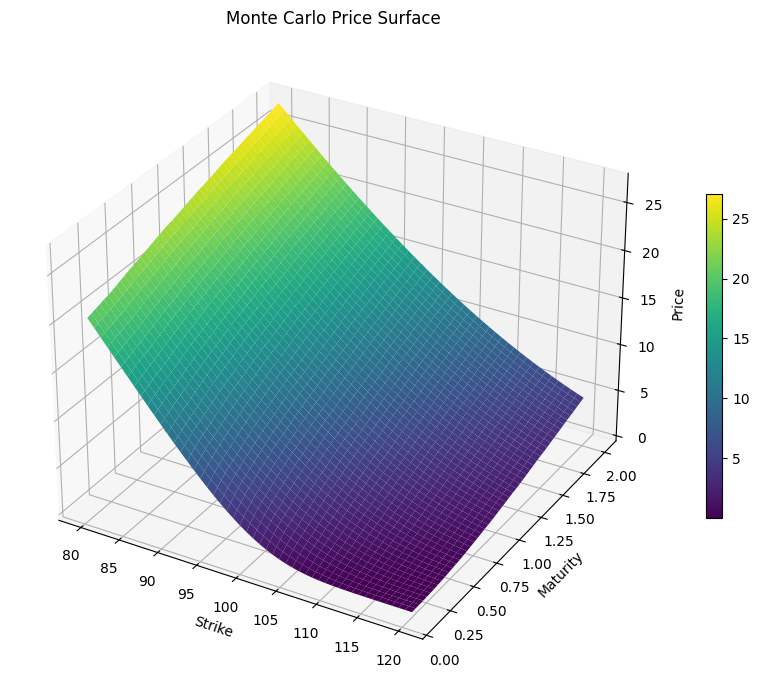

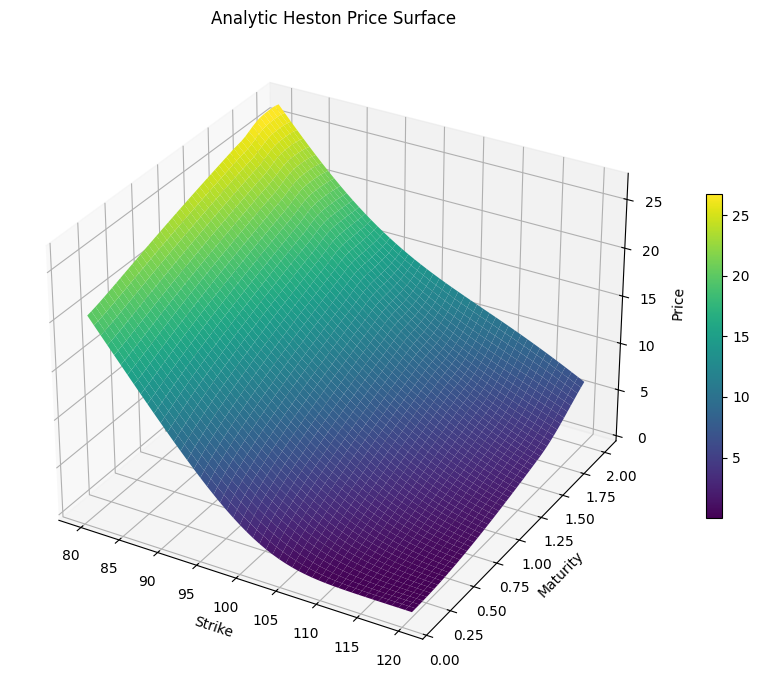

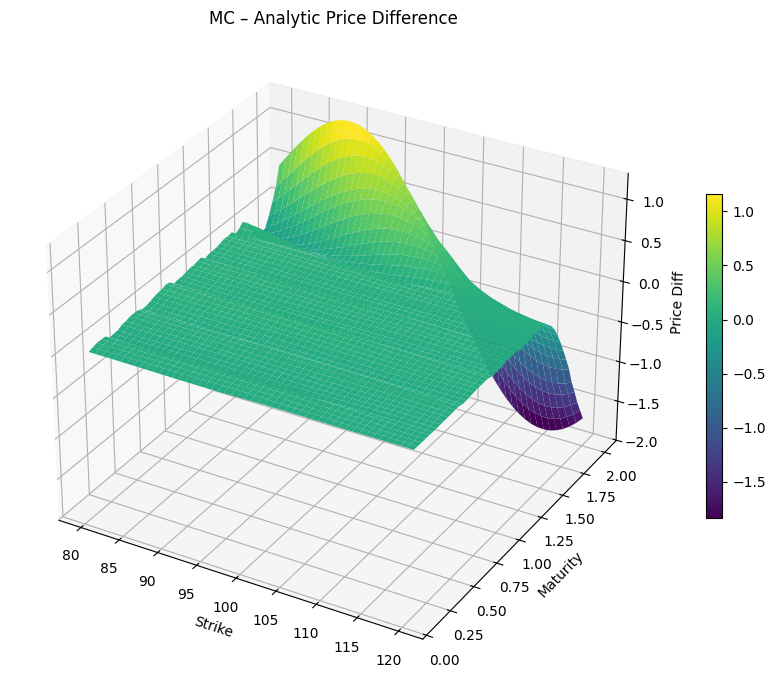

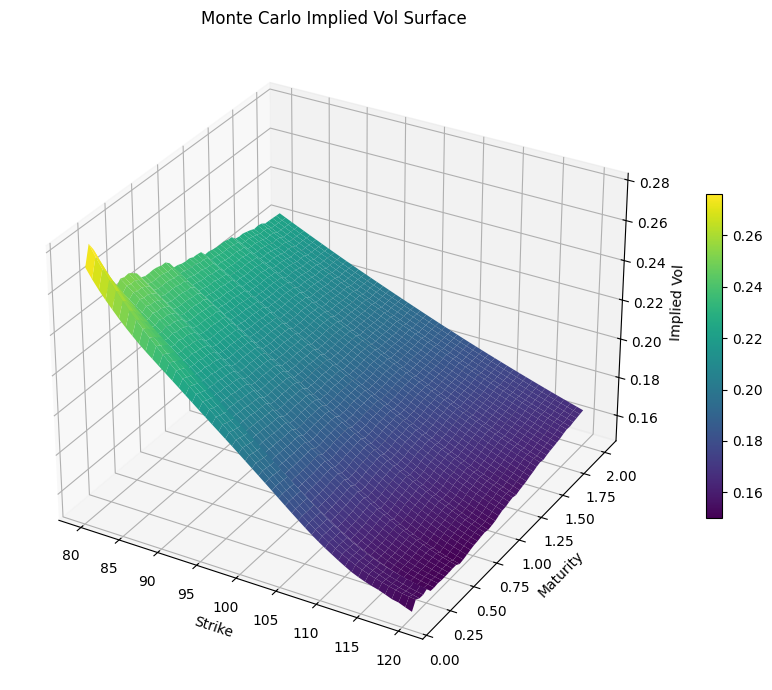

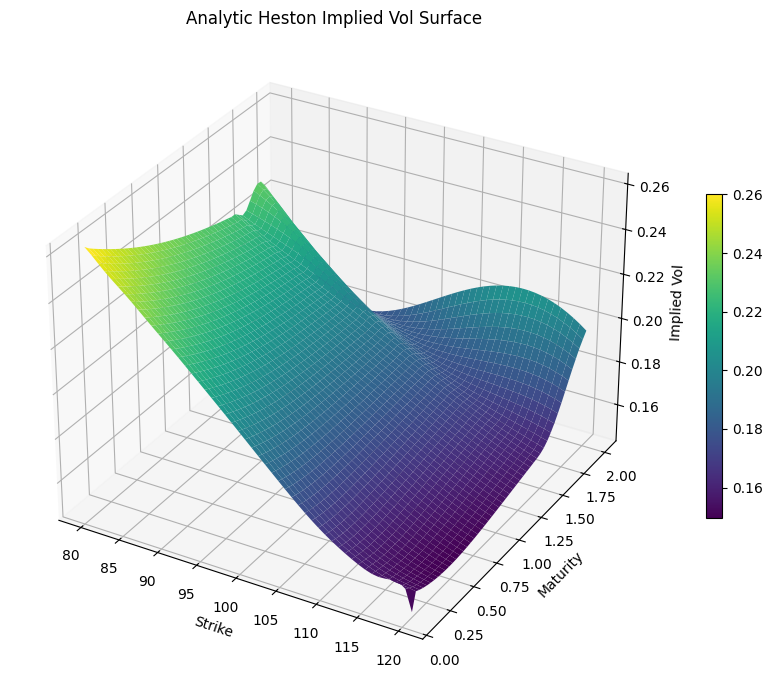

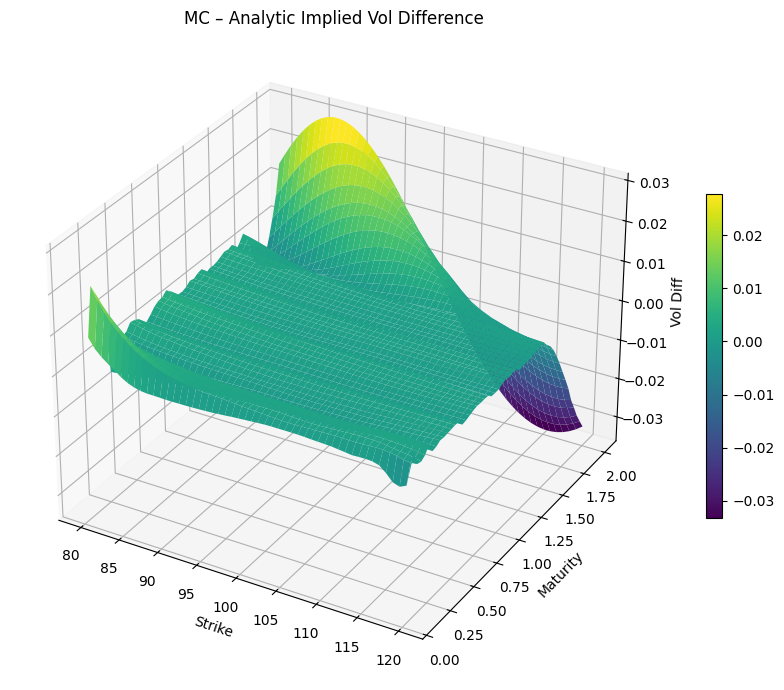

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import brentq
from mpl_toolkits.mplot3d import Axes3D

# Heston parameters and market data
S0 = 100.0
r = 0.03
kappa = 1.5
theta = 0.04
sigma = 0.4
rho = -0.7
V0 = 0.04

# Strike and maturity grid
strikes = np.linspace(80, 120, 50)
maturities = np.linspace(0.1, 2.0, 50)
K_grid, T_grid = np.meshgrid(strikes, maturities, indexing='ij')

# Black-Scholes pricing and implied vol
def bs_price(vol, S, K, T, r):
    d1 = (np.log(S/K) + (r + 0.5*vol**2)*T) / (vol * np.sqrt(T))
    d2 = d1 - vol * np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r*T) * norm.cdf(d2)

def implied_vol(price, S, K, T, r):
    intrinsic = max(S - K*np.exp(-r*T), 0)
    if price <= intrinsic + 1e-12 or price >= S - 1e-12:
        return np.nan
    f = lambda v: bs_price(v, S, K, T, r) - price
    try:
        return brentq(f, 1e-6, 5.0)
    except ValueError:
        return np.nan

# Semi-closed Heston pricing
def heston_price(S0, K, T):
    def phi(j, u):
        if j == 1:
            b, u_shift = kappa - rho*sigma, 0.5
        else:
            b, u_shift = kappa, -0.5
        a = kappa*theta
        x = np.log(S0)
        d = np.sqrt((rho*sigma*1j*u - b)**2 - sigma**2 * (2*u_shift*1j*u - u**2))
        d = np.where(np.real(d) < 0, -d, d)
        g = (b - rho*sigma*1j*u + d) / (b - rho*sigma*1j*u - d)
        C = r*1j*u*T + (a/sigma**2)*((b - rho*sigma*1j*u + d)*T - 2*np.log((1 - g*np.exp(d*T))/(1 - g)))
        D = ((b - rho*sigma*1j*u + d)/sigma**2) * ((1 - np.exp(d*T))/(1 - g*np.exp(d*T)))
        return np.exp(C + D*V0 + 1j*u*x)

    def integrate_P(j):
        U_max, N = 100.0, 5000
        u_vals = np.linspace(0.0, U_max, N+1)
        u_vals[0] = 1e-8
        f = np.real(np.exp(-1j*u_vals*np.log(K)) * phi(j, u_vals) / (1j*u_vals))
        h = U_max/N
        return 0.5 + (h/(3.0*np.pi)) * (f[0] + f[-1] + 4*np.sum(f[1:-1:2]) + 2*np.sum(f[2:-1:2]))

    P2 = integrate_P(2)
    P1 = integrate_P(1)
    return S0 * P1 - K * np.exp(-r*T) * P2

# Monte Carlo QE simulation
def simulate_heston_QE(N_paths, maturities, dt=0.01):
    maturities = sorted(maturities)
    T_max = maturities[-1]
    N_steps = int(round(T_max / dt))
    maturity_steps = [int(round(T / dt)) for T in maturities]
    logS = np.full(N_paths, np.log(S0))
    V = np.full(N_paths, V0)
    results = {}
    next_idx = 0
    E = np.exp(-kappa * dt)

    for step in range(1, N_steps+1):
        m = theta + (V - theta)*E
        s2 = (V * sigma**2 * E / kappa) * (1 - E) + (theta * sigma**2/(2*kappa)) * ((1 - E)**2)
        psi = s2 / (m * m)
        Z_v = np.random.normal(size=N_paths)
        U = np.random.rand(N_paths)
        mask_I = psi <= 1.5
        b2 = 2/psi[mask_I] - 1 + np.sqrt(2/psi[mask_I]) * np.sqrt(2/psi[mask_I] - 1)
        a = m[mask_I] / (1 + b2)
        V_new_I = a * (np.sqrt(b2) + Z_v[mask_I])**2
        mask_II = ~mask_I
        p = (psi[mask_II] - 1) / (psi[mask_II] + 2)
        beta = (1 - p) / m[mask_II]
        U_II = U[mask_II]
        V_new_II = np.where(U_II <= p, 0.0, -np.log((1 - p) / (1 - U_II)) / beta)
        V_new = np.empty_like(V)
        V_new[mask_I] = V_new_I
        V_new[mask_II] = V_new_II
        V_new[V_new < 0] = 0.0
        Z_s = np.random.normal(size=N_paths)
        gamma1 = gamma2 = 0.5
        K0 = -rho * kappa * theta / sigma * dt + r * dt
        K1 = gamma1*dt*(kappa*rho/sigma - 0.5) - rho/sigma
        K2 = gamma2*dt*(kappa*rho/sigma - 0.5) + rho/sigma
        K3 = gamma1*dt*(1 - rho**2)
        K4 = gamma2*dt*(1 - rho**2)
        logS += K0 + K1*V + K2*V_new + np.sqrt(np.maximum(K3*V + K4*V_new, 0.0)) * Z_s
        V = V_new
        if next_idx < len(maturity_steps) and step == maturity_steps[next_idx]:
            T_val = maturities[next_idx]
            results[T_val] = np.exp(logS.copy())
            next_idx += 1
    return results

# Compute surfaces
MC_prices = np.zeros_like(K_grid)
AN_prices = np.zeros_like(K_grid)
MC_iv = np.zeros_like(K_grid)
AN_iv = np.zeros_like(K_grid)
maturities_list = list(np.unique(T_grid))
mc_paths = simulate_heston_QE(100000, maturities_list)

for i, K in enumerate(strikes):
    for j, T in enumerate(maturities):
        ST = mc_paths[T]
        MC_prices[i,j] = np.exp(-r * T) * np.mean(np.maximum(ST - K, 0))
        AN_prices[i,j] = heston_price(S0, K, T)
        MC_iv[i,j] = implied_vol(MC_prices[i,j], S0, K, T, r)
        AN_iv[i,j] = implied_vol(AN_prices[i,j], S0, K, T, r)

# Difference surfaces
price_diff = MC_prices - AN_prices
iv_diff = MC_iv - AN_iv

# RMSE metrics
rmse_price = np.sqrt(np.nanmean((MC_prices - AN_prices)**2))
rmse_iv = np.sqrt(np.nanmean((MC_iv - AN_iv)**2))

print(f"RMSE (Price): {rmse_price:.6f}")
print(f"RMSE (Implied Vol): {rmse_iv:.6f}")

# Plotting
def plot_surface(X, Y, Z, title, zlabel):
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none')
    ax.set_xlabel('Strike')
    ax.set_ylabel('Maturity')
    ax.set_zlabel(zlabel)
    ax.set_title(title)
    fig.colorbar(surf, shrink=0.5)
    plt.tight_layout()

# Original surfaces
plot_surface(K_grid, T_grid, MC_prices, "Monte Carlo Price Surface", "Price")
plot_surface(K_grid, T_grid, AN_prices, "Analytic Heston Price Surface", "Price")
# Difference surfaces
plot_surface(K_grid, T_grid, price_diff, "MC – Analytic Price Difference", "Price Diff")
# Implied vol surfaces
plot_surface(K_grid, T_grid, MC_iv, "Monte Carlo Implied Vol Surface", "Implied Vol")
plot_surface(K_grid, T_grid, AN_iv, "Analytic Heston Implied Vol Surface", "Implied Vol")
# Difference surfaces
plot_surface(K_grid, T_grid, iv_diff, "MC – Analytic Implied Vol Difference", "Vol Diff")


In [ ]:
strikes    = np.linspace(80, 120, 50).tolist()
maturities = np.linspace(0.1, 2.0, 50).tolist()

print("Strikes:", strikes)
print("Maturities:", maturities)


Strikes: [80.0, 80.81632653061224, 81.63265306122449, 82.44897959183673, 83.26530612244898, 84.08163265306122, 84.89795918367346, 85.71428571428571, 86.53061224489795, 87.34693877551021, 88.16326530612245, 88.9795918367347, 89.79591836734694, 90.61224489795919, 91.42857142857143, 92.24489795918367, 93.06122448979592, 93.87755102040816, 94.6938775510204, 95.51020408163265, 96.3265306122449, 97.14285714285714, 97.9591836734694, 98.77551020408163, 99.59183673469389, 100.40816326530611, 101.22448979591837, 102.04081632653062, 102.85714285714286, 103.6734693877551, 104.48979591836735, 105.3061224489796, 106.12244897959184, 106.93877551020408, 107.75510204081633, 108.57142857142857, 109.38775510204081, 110.20408163265306, 111.0204081632653, 111.83673469387756, 112.65306122448979, 113.46938775510205, 114.28571428571428, 115.10204081632654, 115.91836734693878, 116.73469387755102, 117.55102040816327, 118.36734693877551, 119.18367346938776, 120.0]
Maturities: [0.1, 0.13877551020408163, 0.1775510

QUESTION 2.3

`ftol` termination condition is satisfied.
Function evaluations 34, initial cost 4.2356e-01, final cost 1.2510e-01, first-order optimality 4.93e-03.

=== 2023 11 01 Calibration ===
Params [κ,θ,σ,ρ,v₀] = [ 9.0157  0.0444  2.5207 -0.7004  0.0545]
RMSE = 0.0389, MAE = 0.0193, MaxErr = 0.3302


/var/folders/q8/nf645rpd7xd2_wslc8zd02zw0000gn/T/ipykernel_1518/2767840424.py:65: RuntimeWarning: divide by zero encountered in divide
  step = np.where(vega>1e-8, diff/vega, 0.0)


`xtol` termination condition is satisfied.
Function evaluations 23, initial cost 5.3717e-01, final cost 1.2777e-01, first-order optimality 3.77e-02.

=== 2023 11 23 Calibration ===
Params [κ,θ,σ,ρ,v₀] = [ 4.3453  0.048   1.5589 -0.7664  0.0623]
RMSE = 0.0394, MAE = 0.0237, MaxErr = 0.1933


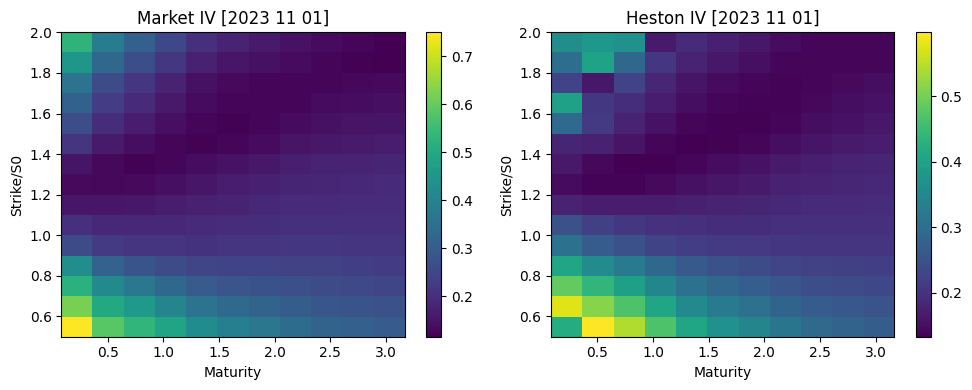

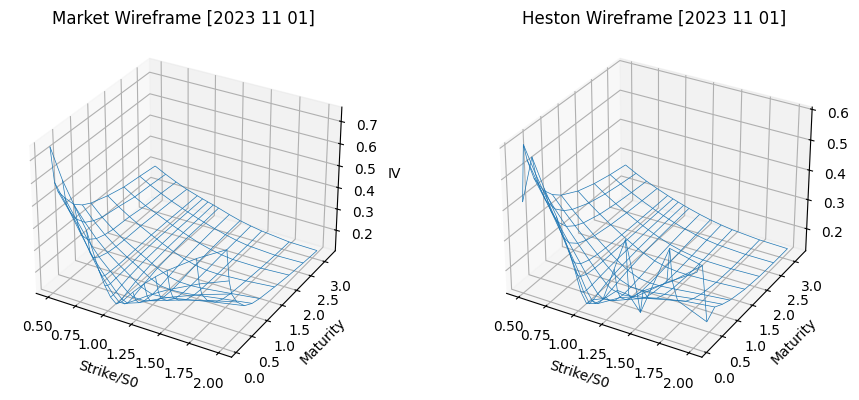

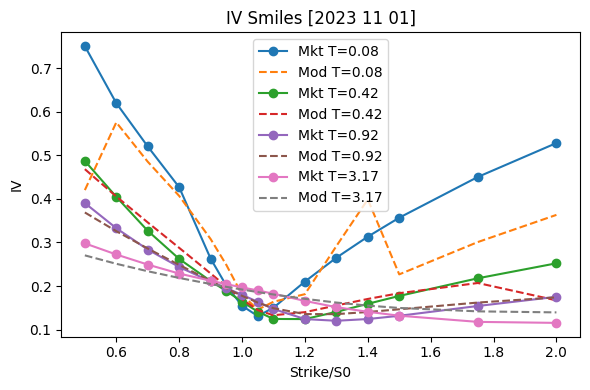

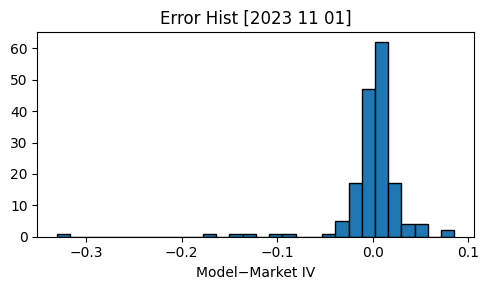

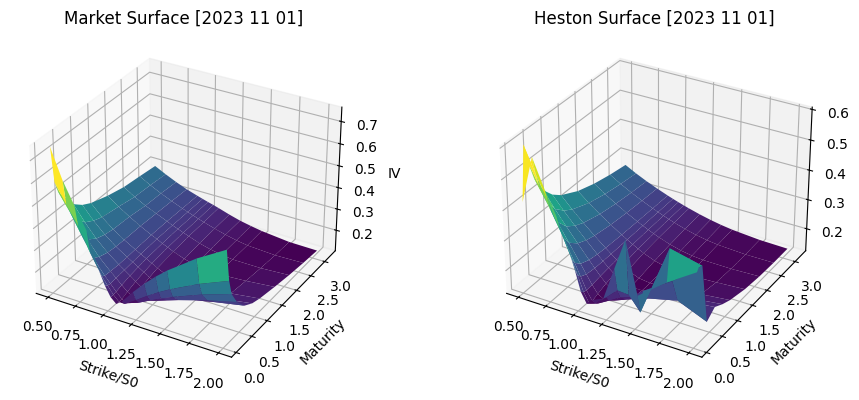

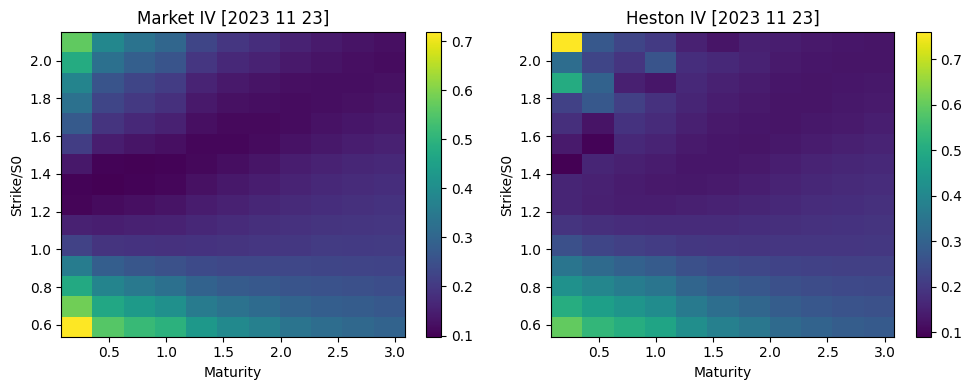

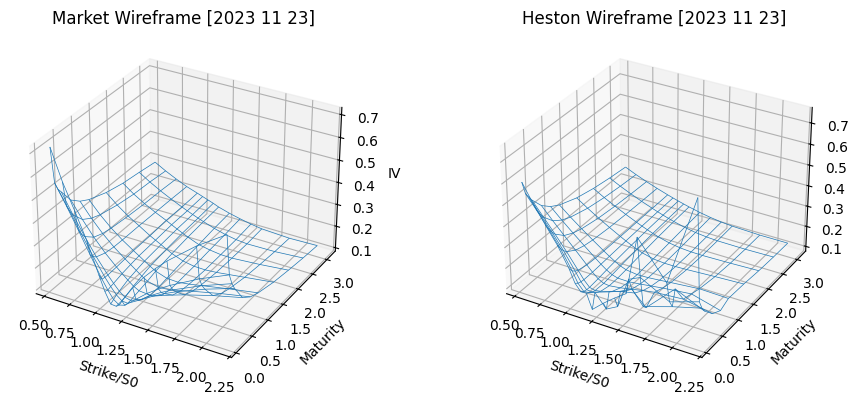

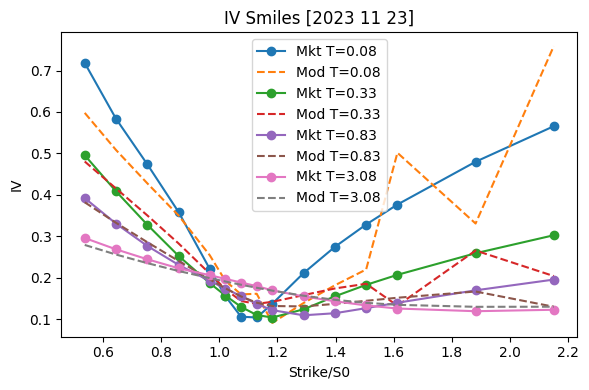

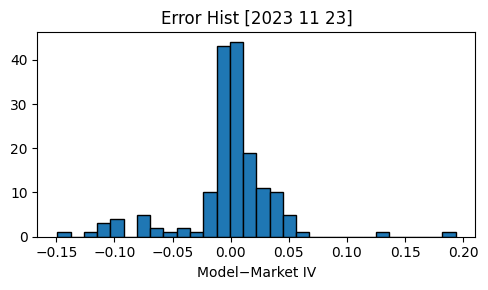

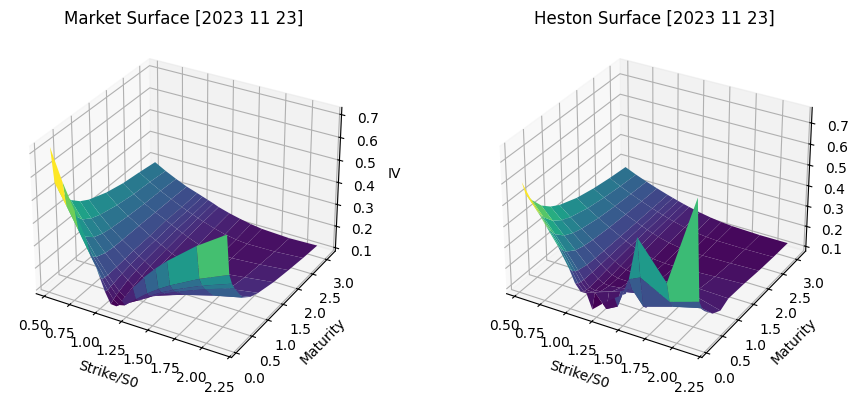

In [3]:
#!/usr/bin/env python3
import numpy as np, math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import least_squares
from scipy.special import erf

# 1) Load raw data
raw = np.load("raw_ivol_surfaces.npy", allow_pickle=True).item()
dates = ["2023 11 01", "2023 11 23"]
r = 0.01  # constant risk-free rate
S0 = 4237.86

# 2) Vectorized Black–Scholes call price
def bs_call_price_arr(S, K, r, T, sigma):
    price = np.zeros_like(K, dtype=float)
    mask = (T > 0) & (sigma > 1e-8)
    d1 = np.zeros_like(K); d2 = np.zeros_like(K)
    d1[mask] = (np.log(S[mask]/K[mask]) + (r + 0.5*sigma[mask]**2)*T[mask]) \
               / (sigma[mask]*np.sqrt(T[mask]))
    d2[mask] = d1[mask] - sigma[mask]*np.sqrt(T[mask])
    Phi = lambda x: 0.5*(1 + erf(x/np.sqrt(2)))
    price[mask] = S[mask]*Phi(d1[mask]) \
                  - K[mask]*np.exp(-r*T[mask])*Phi(d2[mask])
    price[~mask] = np.maximum(S[~mask] - K[~mask]*np.exp(-r*T[~mask]), 0.0)
    return price

# 3) Heston CF pricer
def HestonPrice(S0, K, T, r, params, N=500, umax=200):
    kappa, theta, sigma, rho, v0 = params
    i = 1j
    def char(u):
        xi = kappa - rho*sigma*i*u
        d  = np.sqrt(xi*xi + sigma*sigma*(u*u + i*u))
        g2 = (xi - d)/(xi + d)
        exp_dT = np.exp(-d*T)
        C = r*i*u*T + (kappa*theta/sigma**2)*((xi - d)*T - 2.0*np.log((1-g2*exp_dT)/(1-g2)))
        D = ((xi - d)/sigma**2)*((1-exp_dT)/(1-g2*exp_dT))
        return np.exp(C + D*v0 + i*u*np.log(S0))

    phi_mi = char(-1j)
    u = np.linspace(1e-6, umax, N)
    phi_u    = char(u)
    phi_u_m1 = char(u - 1j)

    integrand2 = np.real(np.exp(-1j*u*np.log(K)) * phi_u    / (1j*u))
    integrand1 = np.real(np.exp(-1j*u*np.log(K)) * phi_u_m1 / (1j*u) / phi_mi)

    P2 = 0.5 + (1/np.pi)*np.trapezoid(integrand2, u)
    P1 = 0.5 + (1/np.pi)*np.trapezoid(integrand1, u)

    call = S0*P1 - K*math.exp(-r*T)*P2
    intrinsic = max(S0 - K*math.exp(-r*T), 0.0)
    return max(call, intrinsic + 1e-12)

# 4) Implied vol inverter
def implied_vols(S0, Ks, Ts, prices, vol_guess, r):
    sigma = vol_guess.copy()
    for _ in range(30):
        bs_p = bs_call_price_arr(np.full_like(Ks, S0), Ks, r, Ts, sigma)
        with np.errstate(divide='ignore', invalid='ignore'):
            d1 = (np.log(S0/Ks) + (r + 0.5*sigma**2)*Ts) / (sigma*np.sqrt(Ts))
            vega = S0*(1/np.sqrt(2*np.pi))*np.exp(-0.5*d1**2)*np.sqrt(Ts)
        diff = bs_p - prices
        step = np.where(vega>1e-8, diff/vega, 0.0)
        sigma -= step
        sigma = np.clip(sigma, 1e-8, 5.0)
        if np.max(np.abs(diff))<1e-6:
            break
    return sigma

# 5) Calibration loop, now with error‐metrics
results = {}
for date in dates:
    tenors   = raw[date]["tenors"]
    strikes  = raw[date]["strikes"]
    vols_mkt = raw[date]["vols"]

    M,N = strikes.shape
    Ks = strikes.flatten(order='F')
    Ts = np.repeat(tenors, M)
    vols_flat = vols_mkt.flatten(order='F')

    def resid(x):
        k,th,si,ro,v0 = x
        if si<=0 or v0<0 or abs(ro)>=1 or k<=0:
            return 1e5 * np.ones_like(vols_flat)
        prices = np.array([
            HestonPrice(S0, Ks[i], Ts[i], r, x, N=300, umax=150)
            for i in range(len(Ks))
        ])
        vols_mod = implied_vols(S0, Ks, Ts, prices, vols_flat, r)
        return vols_mod - vols_flat

    x0     = [2.0, 0.04, 0.5, -0.5, 0.04]
    bounds = ([1e-3,1e-5,1e-4,-0.99,0.0],[15.0,2.0,5.0,0.99,2.0])
    sol = least_squares(resid, x0, bounds=bounds,
                        xtol=1e-6, ftol=1e-6, gtol=1e-6,
                        max_nfev=200, verbose=1)

    #— Print parameters —
    print(f"\n=== {date} Calibration ===")
    print("Params [κ,θ,σ,ρ,v₀] =", np.round(sol.x,4))

    #— Build model vol surface to compute errors —
    prices = np.array([
        HestonPrice(S0, Ks[i], Ts[i], r, sol.x, N=300, umax=150)
        for i in range(len(Ks))
    ])
    vols_mod_flat = implied_vols(S0, Ks, Ts, prices, vols_flat, r)
    vols_mod = vols_mod_flat.reshape((M,N), order='F')
    diff = vols_mod - vols_mkt

    #— Compute and print error metrics —
    rmse    = np.sqrt(np.nanmean(diff**2))
    mae     = np.nanmean(np.abs(diff))
    max_err = np.nanmax(np.abs(diff))
    print(f"RMSE = {rmse:.4f}, MAE = {mae:.4f}, MaxErr = {max_err:.4f}")

    # store for diagnostics
    results[date] = {
        "params": sol.x, "S0": S0,
        "tenors": tenors, "strikes": strikes,
        "vol_mkt": vols_mkt, "vol_mod": vols_mod
    }

# 6) Diagnostics & plotting (market vs model in all plots)
for date, res in results.items():
    κ,θ,σ,ρ,v0 = res["params"]
    S0 = res["S0"]
    T = res["tenors"]
    Kmat = res["strikes"]
    vmkt = res["vol_mkt"]
    M,N = Kmat.shape

    # rebuild model IV
    Kf = Kmat.flatten(order='F')
    Tf = np.repeat(T, M)
    prices = np.array([
        HestonPrice(S0, Kf[i], Tf[i], r, res["params"], N=300, umax=150)
        for i in range(len(Kf))
    ])
    vmodf = implied_vols(S0, Kf, Tf, prices, vmkt.flatten(order='F'), r)
    vmod = vmodf.reshape((M,N), order='F')
    err = (vmod - vmkt).ravel()

    # 6.1 Heatmaps (already good)
    plt.figure(figsize=(10,4))
    for i,(mat,title) in enumerate(zip([vmkt,vmod],["Market IV","Heston IV"])):
        ax = plt.subplot(1,2,i+1)
        ax.set_title(f"{title} [{date}]")
        img = ax.imshow(mat, origin='lower', aspect='auto',
                        extent=[T[0],T[-1],Kmat[0,0]/S0,Kmat[-1,0]/S0],
                        cmap='viridis')
        ax.set_xlabel("Maturity"); ax.set_ylabel("Strike/S0")
        plt.colorbar(img, ax=ax)
    plt.tight_layout(); plt.show()

    # 6.2 Wireframes
    strike_rel = Kmat[:,0]/S0
    TT, KK = np.meshgrid(T, strike_rel)

    fig = plt.figure(figsize=(10,4))
    ax1 = fig.add_subplot(1,2,1, projection='3d')
    ax1.plot_wireframe(KK, TT, vmkt, rstride=1, cstride=1, linewidth=0.5)
    ax1.set_title(f"Market Wireframe [{date}]")
    ax1.set_xlabel("Strike/S0"); ax1.set_ylabel("Maturity"); ax1.set_zlabel("IV")

    ax2 = fig.add_subplot(1,2,2, projection='3d')
    ax2.plot_wireframe(KK, TT, vmod, rstride=1, cstride=1, linewidth=0.5)
    ax2.set_title(f"Heston Wireframe [{date}]")
    ax2.set_xlabel("Strike/S0"); ax2.set_ylabel("Maturity"); ax2.set_zlabel("IV")

    plt.tight_layout(); plt.show()

    # 6.3 Smile slices
    plt.figure(figsize=(6,4))
    for j in [0, N//3, N//2, N-1]:
        plt.plot(Kmat[:,j]/S0, vmkt[:,j], 'o-', label=f"Mkt T={T[j]:.2f}")
        plt.plot(Kmat[:,j]/S0, vmod[:,j], '--', label=f"Mod T={T[j]:.2f}")
    plt.title(f"IV Smiles [{date}]"); plt.xlabel("Strike/S0"); plt.ylabel("IV")
    plt.legend(); plt.tight_layout(); plt.show()

    # 6.4 Error histogram
    plt.figure(figsize=(5,3))
    plt.hist(err[np.isfinite(err)], bins=30, edgecolor='black')
    plt.title(f"Error Hist [{date}]"); plt.xlabel("Model−Market IV")
    plt.tight_layout(); plt.show()

    # 6.5 3D Surface plots
    fig = plt.figure(figsize=(10,4))
    ax1 = fig.add_subplot(1,2,1, projection='3d')
    ax1.plot_surface(KK, TT, vmkt, cmap='viridis', edgecolor='none')
    ax1.set_title(f"Market Surface [{date}]")
    ax1.set_xlabel("Strike/S0"); ax1.set_ylabel("Maturity"); ax1.set_zlabel("IV")

    ax2 = fig.add_subplot(1,2,2, projection='3d')
    ax2.plot_surface(KK, TT, vmod, cmap='viridis', edgecolor='none')
    ax2.set_title(f"Heston Surface [{date}]")
    ax2.set_xlabel("Strike/S0"); ax2.set_ylabel("Maturity"); ax2.set_zlabel("IV")

    plt.tight_layout(); plt.show()



In [2]:
# weather_predictor.py
# A complete Python script to fetch historical weather data and train an LSTM model to predict next-day average temperature.

# === 1. Install dependencies ===
# Run in your terminal:
# pip install meteostat pandas numpy scikit-learn matplotlib tensorflow

# === 2. Imports ===
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from meteostat import Point, Daily
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

# === 3. Configuration ===
# Change to your desired location (latitude, longitude)
LATITUDE = 52.374  # e.g. Amsterdam
LONGITUDE = 4.889
YEARS_OF_HISTORY = 5  # number of years of historical data to use
SEQUENCE_LENGTH = 30  # number of past days to use for one prediction
EPOCHS = 20
BATCH_SIZE = 32

# === 4. Fetch data ===
end = datetime.now()
start = end - timedelta(days=365 * YEARS_OF_HISTORY)
location = Point(LATITUDE, LONGITUDE)

# Fetch daily weather data
print("Fetching data from Meteostat...")
data = Daily(location, start, end)
data = data.fetch()

# Select relevant features and drop missing
features = ['tavg', 'tmin', 'tmax', 'prcp', 'wspd', 'pres', 'rhum']
data = data[features].dropna()

# === 5. Preprocess ===
# Scale all features to 0–1
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# Create sequences for supervised learning
def create_sequences(arr, seq_len):
    X, y = [], []
    for i in range(len(arr) - seq_len):
        X.append(arr[i : i + seq_len])
        # Predict next day's average temperature (tavg is column 0)
        y.append(arr[i + seq_len, 0])
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_data, SEQUENCE_LENGTH)
print(f"Total samples: {len(X)}")

# Split into training and testing sets
split_idx = int(0.8 * len(X))
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# === 6. Build LSTM model ===
model = Sequential([
    LSTM(64, input_shape=(SEQUENCE_LENGTH, X.shape[2]), return_sequences=False),
    Dense(32, activation='relu'),
    Dense(1)  # predicting one value: average temperature
])
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

# === 7. Train ===
history = model.fit(
    X_train,
    y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=0.1,
    verbose=2
)

# === 8. Evaluate ===
loss, mae = model.evaluate(X_test, y_test, verbose=0)
print(f"Test MAE (scaled): {mae:.4f}")

# Convert MAE back to °C by inverting the scaler on a dummy array
dummy_scaled = np.zeros((1, len(features)))
dummy_scaled[0, 0] = mae
inv = scaler.inverse_transform(dummy_scaled)
print(f"Test MAE: {inv[0,0]:.2f} °C")

# === 9. Predict next day ===
last_seq = scaled_data[-SEQUENCE_LENGTH:]
pred_scaled = model.predict(last_seq.reshape(1, SEQUENCE_LENGTH, X.shape[2]))[0]
# Invert scaling
dummy_scaled[0,0] = pred_scaled
pred_inv = scaler.inverse_transform(dummy_scaled)
print(f"Predicted average temperature for next day: {pred_inv[0,0]:.2f} °C")

# === 10. Plot training history ===
plt.figure()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()


ModuleNotFoundError: No module named 'meteostat'